# Agentic Data Science Assistant (SID-ADSA)

This notebook implements a **rule-based, agentic EDA workflow**. The agent:
- observes a dataset (shape, dtypes, missingness)
- plans analysis steps
- executes tools (summaries, plots, correlation, group comparisons)
- generates an EDA report and saves artifacts


## Goal

Build an agent that can inspect a dataset and automatically produce:
- an **EDA summary report**
- a few **standard plots**
- **saved artifacts** (report + plots) for GitHub review


## Agent Loop (high-level)

1. **Observe**: dataset shape, column types, missingness  
2. **Plan**: choose analysis steps based on what it sees  
3. **Act**: run tool functions (EDA + plots)  
4. **Remember**: store actions + results in agent memory  
5. **Output**: generate a final report and save artifacts


## Outputs

After running all cells, the notebook should produce:
- `outputs/report.md` (EDA report)
- `outputs/plots/*.png` (saved histogram images)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv")
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## Utilities (Filesystem helpers)

In [8]:
import os
from datetime import datetime

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)


In [9]:
def tool_dataset_overview(df: pd.DataFrame) -> dict:
    info = {
        "rows": df.shape[0],
        "cols": df.shape[1],
        "columns": df.columns.tolist(),
        "dtypes": df.dtypes.astype(str).to_dict(),
        "missing": df.isna().sum().to_dict()
    }
    return info


def tool_numeric_summary(df: pd.DataFrame) -> pd.DataFrame:
    return df.describe(include=[np.number]).T


def tool_categorical_summary(df: pd.DataFrame) -> pd.DataFrame:
    cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    summaries = {}
    for c in cat_cols:
        summaries[c] = df[c].value_counts(dropna=False).head(10)
    return summaries


# def tool_histograms(df: pd.DataFrame, max_cols: int = 3) -> list:
#     num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
#     chosen = num_cols[:max_cols]
#     made = []
#     for c in chosen:
#         plt.figure()
#         df[c].dropna().hist()
#         plt.title(f"Histogram: {c}")
#         plt.xlabel(c)
#         plt.ylabel("Count")
#         plt.show()
#         made.append(c)
#     return made





def tool_histograms(df: pd.DataFrame, max_cols: int = 3, out_dir: str = "outputs/plots") -> list:
    ensure_dir(out_dir)

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    chosen = num_cols[:max_cols]
    saved_files = []

    for c in chosen:
        plt.figure()
        df[c].dropna().hist()
        plt.title(f"Histogram: {c}")
        plt.xlabel(c)
        plt.ylabel("Count")

        filepath = os.path.join(out_dir, f"hist_{c}.png")
        plt.savefig(filepath, bbox_inches="tight")
        plt.close()

        saved_files.append(filepath)

    return saved_files



In [10]:
def save_report_md(report_text: str, out_dir: str = "outputs") -> str:
    ensure_dir(out_dir)
    filepath = os.path.join(out_dir, "report.md")
    with open(filepath, "w", encoding="utf-8") as f:
        f.write("# SID-ADSA EDA Report\n\n")
        f.write(f"Generated: {datetime.now().isoformat(timespec='seconds')}\n\n")
        f.write(report_text)
        f.write("\n")
    return filepath

In [11]:
class SimpleEDAgent:
    def __init__(self, goal: str):
        self.goal = goal
        self.memory = {
            "goal": goal,
            "actions": [],
            "notes": []
        }

    def plan(self, df: pd.DataFrame) -> list:
        """
        Rule-based planner:
        Always do overview -> numeric summary -> categorical summary -> histograms
        """
        return ["overview", "numeric_summary", "categorical_summary", "histograms"]

    def act(self, df: pd.DataFrame, action: str):
        if action == "overview":
            result = tool_dataset_overview(df)
            self.memory["actions"].append(action)
            self.memory["notes"].append(("overview", result))
            return result

        if action == "numeric_summary":
            result = tool_numeric_summary(df)
            self.memory["actions"].append(action)
            self.memory["notes"].append(("numeric_summary", result))
            return result

        if action == "categorical_summary":
            result = tool_categorical_summary(df)
            self.memory["actions"].append(action)
            self.memory["notes"].append(("categorical_summary", result))
            return result

        if action == "histograms":
            result = tool_histograms(df, max_cols=3)
            self.memory["actions"].append(action)
            self.memory["notes"].append(("histograms", result))
            return result

        raise ValueError(f"Unknown action: {action}")

    def run(self, df: pd.DataFrame):
        plan = self.plan(df)

        outputs = {}
        for step in plan:
            outputs[step] = self.act(df, step)

        return outputs


In [12]:
agent = SimpleEDAgent(goal="Run basic EDA and generate a starter report.")
outputs = agent.run(df)

# Show key outputs
outputs["overview"]


{'rows': 344,
 'cols': 7,
 'columns': ['species',
  'island',
  'bill_length_mm',
  'bill_depth_mm',
  'flipper_length_mm',
  'body_mass_g',
  'sex'],
 'dtypes': {'species': 'object',
  'island': 'object',
  'bill_length_mm': 'float64',
  'bill_depth_mm': 'float64',
  'flipper_length_mm': 'float64',
  'body_mass_g': 'float64',
  'sex': 'object'},
 'missing': {'species': 0,
  'island': 0,
  'bill_length_mm': 2,
  'bill_depth_mm': 2,
  'flipper_length_mm': 2,
  'body_mass_g': 2,
  'sex': 11}}

In [13]:
outputs["numeric_summary"]


,count,mean,std,min,25%,50%,75%,max
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


In [14]:
outputs["categorical_summary"]


{'species': species
 Adelie       152
 Gentoo       124
 Chinstrap     68
 Name: count, dtype: int64,
 'island': island
 Biscoe       168
 Dream        124
 Torgersen     52
 Name: count, dtype: int64,
 'sex': sex
 MALE      168
 FEMALE    165
 NaN        11
 Name: count, dtype: int64}

In [15]:
def tool_missing_report(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum()
    pct = (miss / len(df)) * 100
    report = pd.DataFrame({"missing_count": miss, "missing_pct": pct}).sort_values(
        "missing_count", ascending=False
    )
    return report


def tool_correlation(df: pd.DataFrame) -> pd.DataFrame:
    num_df = df.select_dtypes(include=[np.number])
    if num_df.shape[1] < 2:
        return pd.DataFrame()
    return num_df.corr(numeric_only=True)


def tool_boxplot_by_category(df: pd.DataFrame, numeric_col: str, category_col: str):
    # simple boxplot (matplotlib) without extra styling
    data = []
    labels = []
    for cat in df[category_col].dropna().unique():
        vals = df.loc[df[category_col] == cat, numeric_col].dropna().values
        if len(vals) > 0:
            data.append(vals)
            labels.append(str(cat))

    if len(data) == 0:
        return

    plt.figure()
    plt.boxplot(data, labels=labels)
    plt.title(f"{numeric_col} by {category_col}")
    plt.xlabel(category_col)
    plt.ylabel(numeric_col)
    plt.show()


In [16]:
class SmartEDAgent:
    def __init__(self, goal: str):
        self.goal = goal
        self.memory = {
            "goal": goal,
            "actions": [],
            "notes": []
        }

    def observe(self, df: pd.DataFrame) -> dict:
        overview = tool_dataset_overview(df)
        missing_report = tool_missing_report(df)
        obs = {
            "overview": overview,
            "missing_report": missing_report
        }
        self.memory["notes"].append(("observation", obs))
        return obs

    def plan(self, df: pd.DataFrame, obs: dict) -> list:
        plan = ["overview"]

        # Always: if missing exists, generate missing report
        missing_total = sum(obs["overview"]["missing"].values())
        if missing_total > 0:
            plan.append("missing_report")

        # If numeric columns exist, do numeric summary + histograms
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(num_cols) > 0:
            plan.append("numeric_summary")
            plan.append("histograms")

        # If categorical columns exist, do categorical summary
        cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
        if len(cat_cols) > 0:
            plan.append("categorical_summary")

        # If multiple numeric columns exist, add correlation
        if len(num_cols) >= 2:
            plan.append("correlation")

        # If we have at least 1 numeric and 1 categorical, do a boxplot
        if len(num_cols) >= 1 and len(cat_cols) >= 1:
            plan.append("boxplot_best")

        plan.append("save_report")

        return plan

    def act(self, df: pd.DataFrame, action: str):
        self.memory["actions"].append(action)

        if action == "overview":
            result = tool_dataset_overview(df)

        elif action == "missing_report":
            result = tool_missing_report(df)

        elif action == "numeric_summary":
            result = tool_numeric_summary(df)

        elif action == "categorical_summary":
            result = tool_categorical_summary(df)

        elif action == "histograms":
            result = tool_histograms(df, max_cols=3)

        elif action == "correlation":
            result = tool_correlation(df)

        elif action == "boxplot_best":
            # pick: numeric with most variance + first categorical
            num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
            cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

            if len(num_cols) == 0 or len(cat_cols) == 0:
                result = "Skipped (no num/cat columns)."
            else:
                # choose numeric with highest std dev (more informative)
                stds = df[num_cols].std(numeric_only=True).sort_values(ascending=False)
                best_num = stds.index[0]
                best_cat = cat_cols[0]
                tool_boxplot_by_category(df, best_num, best_cat)
                result = {"numeric": best_num, "category": best_cat}

        elif action == "save_report":
            # find the final report text saved in memory
            report_text = None
            for k, v in self.memory["notes"]:
                if k == "final_report":
                    report_text = v
                    break
                    
            if report_text is None:
                report_text = "No report found in memory."
                
            result = save_report_md(report_text, out_dir="outputs")


        else:
            raise ValueError(f"Unknown action: {action}")

        self.memory["notes"].append((action, result))
        return result

    def generate_report(self) -> str:
        # Pull key facts from memory
        overview = None
        missing_report = None

        for k, v in self.memory["notes"]:
            if k == "overview":
                overview = v
            if k == "missing_report":
                missing_report = v

        lines = []
        lines.append(f"Goal: {self.goal}")

        if overview:
            lines.append(f"Dataset shape: {overview['rows']} rows × {overview['cols']} columns.")
            lines.append("Columns: " + ", ".join(overview["columns"]) + ".")
            # missing highlights
            miss = overview["missing"]
            top_missing = sorted(miss.items(), key=lambda x: x[1], reverse=True)
            top_missing = [x for x in top_missing if x[1] > 0]
            if top_missing:
                lines.append("Missing values detected (top): " + ", ".join([f"{c}={n}" for c, n in top_missing[:5]]) + ".")
            else:
                lines.append("No missing values detected.")

        if isinstance(missing_report, pd.DataFrame) and not missing_report.empty:
            worst = missing_report.iloc[0]
            worst_col = missing_report.index[0]
            if worst["missing_count"] > 0:
                lines.append(f"Most missing column: {worst_col} ({int(worst['missing_count'])} missing, {worst['missing_pct']:.2f}%).")

        # action log
        lines.append("Actions executed: " + " → ".join(self.memory["actions"]) + ".")

        # simple recommendations
        lines.append("Recommendations:")
        lines.append("- Decide a missing-value strategy (drop rows for tiny missingness, or impute if needed).")
        lines.append("- Use category vs numeric comparisons (boxplots) to compare groups.")
        lines.append("- Review correlations to spot relationships between numeric variables.")

        return "\n".join(lines)

    def run(self, df: pd.DataFrame):
        obs = self.observe(df)
        plan = self.plan(df, obs)

        outputs = {}
        for step in plan:
            outputs[step] = self.act(df, step)

        report = self.generate_report()
        outputs["report"] = report
        self.memory["notes"].append(("final_report", report))
        return outputs


C:\Users\bhadr\AppData\Local\Temp\ipykernel_22220\3427927954.py:31: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


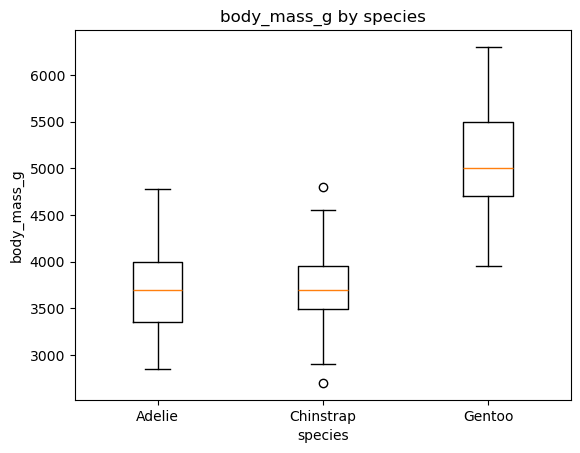

Goal: Run smart EDA and produce an auto report.
Dataset shape: 344 rows × 7 columns.
Columns: species, island, bill_length_mm, bill_depth_mm, flipper_length_mm, body_mass_g, sex.
Missing values detected (top): sex=11, bill_length_mm=2, bill_depth_mm=2, flipper_length_mm=2, body_mass_g=2.
Most missing column: sex (11 missing, 3.20%).
Actions executed: overview → missing_report → numeric_summary → histograms → categorical_summary → correlation → boxplot_best → save_report.
Recommendations:
- Decide a missing-value strategy (drop rows for tiny missingness, or impute if needed).
- Use category vs numeric comparisons (boxplots) to compare groups.
- Review correlations to spot relationships between numeric variables.


In [17]:
smart_agent = SmartEDAgent(goal="Run smart EDA and produce an auto report.")
smart_outputs = smart_agent.run(df)

print(smart_outputs["report"])


In [18]:
smart_outputs["missing_report"]


,missing_count,missing_pct
sex,11,3.197674
bill_length_mm,2,0.581395
bill_depth_mm,2,0.581395
flipper_length_mm,2,0.581395
body_mass_g,2,0.581395
species,0,0.000000
island,0,0.000000


In [19]:
smart_outputs["missing_report"].head()

,missing_count,missing_pct
sex,11,3.197674
bill_length_mm,2,0.581395
bill_depth_mm,2,0.581395
flipper_length_mm,2,0.581395
body_mass_g,2,0.581395


In [20]:
smart_outputs["correlation"]


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
bill_length_mm,1.000000,-0.235053,0.656181,0.595110
bill_depth_mm,-0.235053,1.000000,-0.583851,-0.471916
flipper_length_mm,0.656181,-0.583851,1.000000,0.871202
body_mass_g,0.595110,-0.471916,0.871202,1.000000


In [21]:
smart_outputs["boxplot_best"]

{'numeric': 'body_mass_g', 'category': 'species'}

In [22]:
smart_agent.memory["actions"]

['overview',
 'missing_report',
 'numeric_summary',
 'histograms',
 'categorical_summary',
 'correlation',
 'boxplot_best',
 'save_report']

In [23]:
smart_agent = SmartEDAgent(goal="test")
obs = smart_agent.observe(df)
plan = smart_agent.plan(df, obs)
plan

['overview',
 'missing_report',
 'numeric_summary',
 'histograms',
 'categorical_summary',
 'correlation',
 'boxplot_best',
 'save_report']

In [24]:
import os
os.path.exists("outputs/report.md")


True